# Extended Data Figure 10

![title](../assets/EDFig10.png)

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import logging
from tqdm import tqdm
from pathlib import Path

sys.path.insert(0, "./prepare_data/")

import yaml
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
from matplotlib import gridspec
import matplotlib_venn
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import Figure4_neurons as neurons
import Figure4_graph_tools as graph_tools
import connectome_utils
from common import *

# import plot_utils

DATA_PATH = Path(
    "../data"
)
EXPORT_PATH = Path(
    "../results/EDFigure10"
)
EXPORT_PATH.mkdir(exist_ok=True, parents=True)


FIGSIZE = {'width': 1.2, 'length': 0.9}

# disable matplotlib logger
logging.getLogger("matplotlib.font_manager").disabled = True

plt.style.use('./config.mplstyle')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Panel A: training data generation
*TODO*

## Panel B: symmetrizing the adjacency matrix

In [6]:
orig_adj_matrix = np.load(DATA_PATH / "EDFig10_orig_adj_matrix.npy").T
neurons_ordered = load_data(DATA_PATH / "EDFig10_neurons_ordered.pkl")

neuron_count_half = orig_adj_matrix.shape[0] // 2
# Symmetrize the matrix - using the max connection approach
# Determine the sign for each neuron based on its type
signs = np.array(
    [
        -1 if neuron_data["nt"] == "inhibitory" else 1
        for _, neuron_data in neurons_ordered.items()
    ]
)

# Separate ipsilateral and contralateral connections
ipsilateral_left = np.abs(orig_adj_matrix[:neuron_count_half, :neuron_count_half])
ipsilateral_right = np.abs(orig_adj_matrix[neuron_count_half:, neuron_count_half:])
contralateral_left_to_right = np.abs(
    orig_adj_matrix[:neuron_count_half, neuron_count_half:]
)
contralateral_right_to_left = np.abs(
    orig_adj_matrix[neuron_count_half:, :neuron_count_half]
)

# Compute the maximum values for ipsilateral and contralateral connections
ipsilateral_max = np.maximum(ipsilateral_left, ipsilateral_right)
contralateral_max = np.maximum(contralateral_left_to_right, contralateral_right_to_left)

# Construct the symmetric adjacency matrix
adj_matrix_symmetric = np.block(
    [[ipsilateral_max, contralateral_max], [contralateral_max, ipsilateral_max]]
)

# Apply the neuron type signs
adj_matrix_symmetric *= signs[:, None]

# Set self-connections to zero
np.fill_diagonal(adj_matrix_symmetric, 0)

# Log the changes in the number of connections and total synapse strength
original_connections = np.count_nonzero(orig_adj_matrix)
symmetric_connections = np.count_nonzero(adj_matrix_symmetric)

print(
    f"Adjacency matrix: connections reduced from {original_connections} to {symmetric_connections}"
)

Adjacency matrix: connections reduced from 4961 to 7772


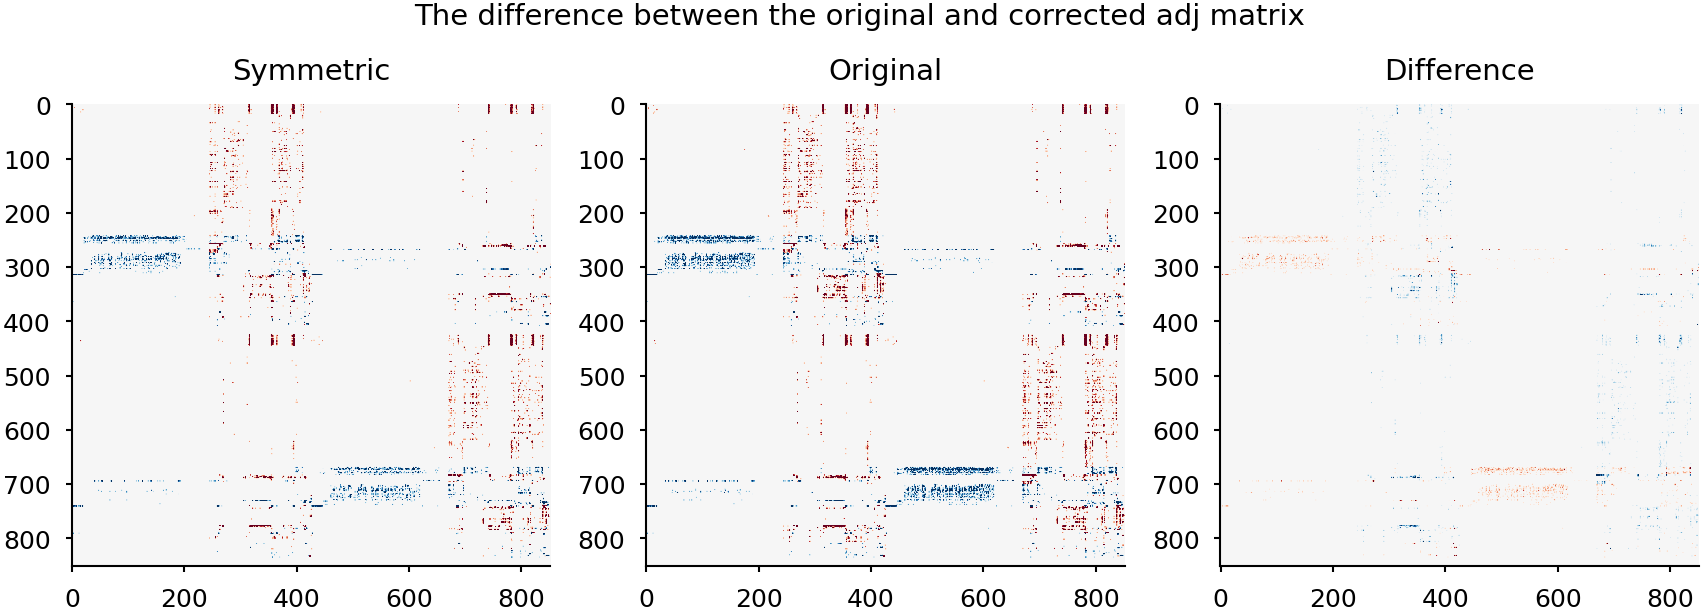

In [8]:
# compare
# plot the adj matrix
# row -> pre, column -> post
fig, ax = plt.subplots(1, 3, figsize=(7, 2))
ax[0].imshow(orig_adj_matrix, cmap="RdBu_r", aspect="auto", vmin=-3, vmax=3)
ax[1].imshow(adj_matrix_symmetric, cmap="RdBu_r", aspect="auto", vmin=-3, vmax=3)
ax[2].imshow(
    orig_adj_matrix - adj_matrix_symmetric,
    cmap="RdBu_r",
    aspect="auto",
    vmin=-10,
    vmax=10,
)
plt.suptitle("The difference between the original and corrected adj matrix", y=1.05)

ax[0].set_title("Symmetric")
ax[1].set_title("Original")
ax[2].set_title("Difference")

plt.show()


## Panel C: test error of different models

/var/folders/tq/lmjf3_8j2pgc58qrzj3pl2x00000gp/T/ipykernel_76388/2713207417.py:6: UserWarning: 
The palette list has fewer values (1) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(


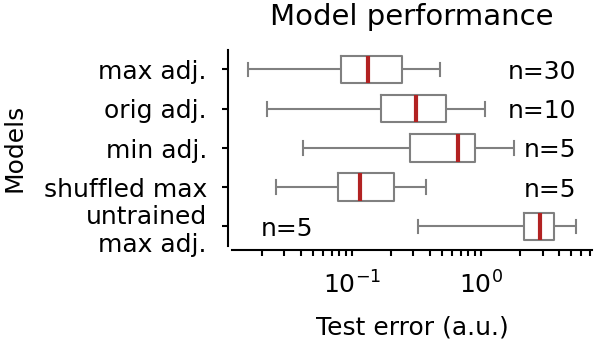

In [4]:
test_error = load_data(DATA_PATH / "EDFig10_panelC.pkl")

with plt.style.context("./config.mplstyle"):
    # plot scores as boxplot
    plt.figure(figsize=(1.55, 0.85))
    sns.boxplot(
        x=test_error['y'],
        y=test_error['x'],
        fill=False,
        showfliers=False,
        linewidth=0.5,
        orient="h",
        width=0.7,
        palette=["grey"],
        medianprops=dict(color="firebrick", linewidth=1),
    )
    sns.despine(offset=1, trim=False)
    plt.xscale("log")
    plt.yticks([0, 1, 2, 3, 4], labels=test_error['labels'], fontsize=6)
    plt.xlabel("Test error (a.u.)")
    plt.ylabel("Models")
    plt.title("Model performance")
    plt.text(5.5, -0.25, "n=30", ha="right", va="top", fontsize=6)
    plt.text(5.5, 0.75, "n=10", ha="right", va="top", fontsize=6)
    plt.text(5.5, 1.75, "n=5", ha="right", va="top", fontsize=6)
    plt.text(5.5, 2.75, "n=5", ha="right", va="top", fontsize=6)
    plt.text(0.05, 3.75, "n=5", ha="right", va="top", fontsize=6)

    plt.savefig(EXPORT_PATH / "EDFig10_panelC.png", bbox_inches="tight", dpi=300)
    plt.show()

## Panel D: neural responses

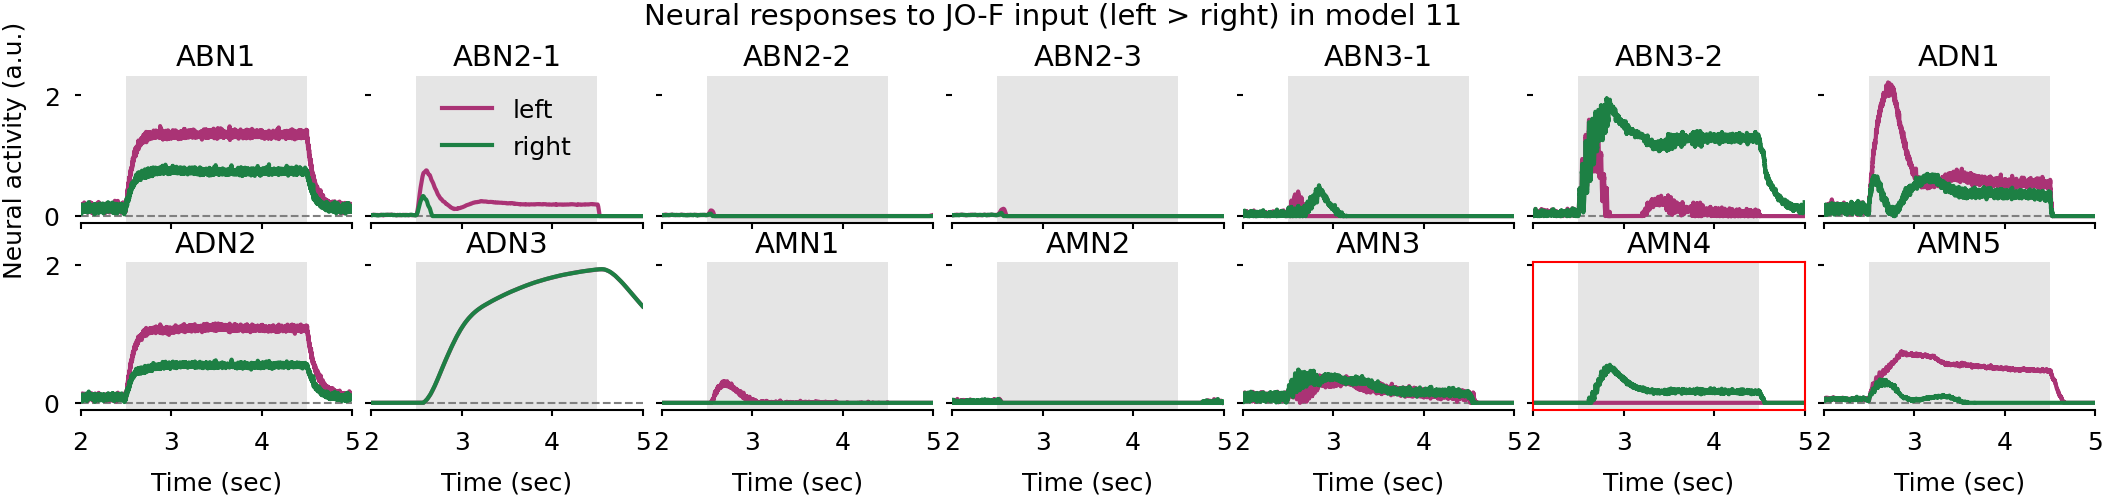

In [5]:
neuron_types = ["ABN", "ADN", "ANTEN_MN"]
neuron_index = np.load(DATA_PATH / "neuron_names_ordered.npy")
left_neurons = [
    i
    for i, name in enumerate(neuron_index)
    for neuron_type in neuron_types
    if neuron_type in name and "L" in name
]
right_neurons = [
    i
    for i, name in enumerate(neuron_index)
    for neuron_type in neuron_types
    if neuron_type in name and "R" in name
]

neuron_names = [
    neuron_index[i][:-2].replace("ANTEN_", "A").replace("_", "-") for i in left_neurons
]

# Plot the traces of the neurons
asym_input_response = load_data(DATA_PATH / "Fig5_panelF_JO-F_L_5_R_3.pkl")

seed = 10
fig, axs = plt.subplots(
    2,
    7,
    figsize=(FIGSIZE["width"] * 5.85, FIGSIZE["length"] * 1.8),
    dpi=300,
    sharex=True,
    sharey="row",
)
axs = axs.flatten()

for i, (left_mn, right_mn) in enumerate(zip(left_neurons, right_neurons)):
    axs[i].axhline(0, color="grey", linewidth=0.5, linestyle="--")
    relu_voltage = relu_function(asym_input_response[seed])

    axs[i].plot(
        relu_voltage[:, left_mn],
        color="#AA3375",
        linewidth=1,
        label='left'
    )
    axs[i].plot(
        relu_voltage[:, right_mn],
        color="#1D8044",
        linewidth=1,
        label='right'
    )
    axs[i].set_title(neuron_names[i], y=0.9)
    axs[i].axvspan(2500, 4500, color="grey", alpha=0.2, linewidth=0)
    axs[i].set_xlim(2000, 5000)
    y_ticks = axs[i].get_yticks()
    axs[i].set_xticks([2000, 3000, 4000, 5000], labels=[2, 3, 4, 5])

    if i != 0 or i != 7:
        axs[i].spines["left"].set_visible(False)
    if i > 6:
        axs[i].set_xlabel("Time (sec)")
    # axs[i].set_xlabel("Time (sec)")
    axs[0].set_ylabel("Neural activity (a.u.)")

    for direction in ["top", "right", "left", "bottom"]:
        axs[12].spines[direction].set_visible(True)
        axs[12].spines[direction].set_color("red")

axs[1].legend()
plt.suptitle(
    "Neural responses to JO-F input (left > right) in model 11", y=1.02, fontsize=7
)
plt.tight_layout(pad=0.1)
fig.savefig(
    EXPORT_PATH / f"EDFig10_panelD_{seed}.png", bbox_inches="tight", dpi=300
)

plt.show()